# Abstract
Today, we are going to build a automated decision system that will be demonstrated using a dataset of borrowers from a bank. The objective of this decising making model is to use the training data to predicting whether a not a future applicant is likely to default a loan or repay it in full. We will use this model not only to demonstrate the creation of a decision making model, but also to assist a larger discussion on its societal impacts.

# Grabbing and Observing the Data

In [3]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df = pd.read_csv(url)

With `df.head()` we can see the features that are associated with each borrower:

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


# Base Rates

To demonstrate that our machine learning model has indeed derived a pattern from the training data, we will try to achieve an accuracy above the base rate. The base rate is the accuracy that we can achieve if we predict one outcome for every possible decision.

In [5]:
1-df["loan_status"].mean()

np.float64(0.7824201964395334)

in this case, `loan_status` equals 1 if the borrower did default on their loan, and 0 if they repaid it in full. `df["loan_status"].mean` gets the percentage of borrowers that defaulted, and subtracting by 1 gives us the perctange of borrows that repaid the loan. If we always predict the applicant will repay the loan, then we will get correct roughly 78% of the time. In order to demonstrate learning by the model, we must aim for an accuracy above 78%.

# Visualizing the Data

We want to make informed decisions on the data, which requires that we search for patterns within that data. One question we may ask is: is there a observable pattern of loan intent with respect to age, length of employment, or homeownership status?

To discover this, we will make visualizations of our dataset to prove or dispprove the relation between age, length of employment, or homeownership status and loan intent. We will make use of the LabelEncoder in order to turn our values of loan intent (venture, education, home improvement) into values that will be easier to work with.

# Summary Table


In [6]:
summary_table = df.groupby("person_home_ownership").agg({
    "loan_amnt": "mean",
    "loan_int_rate": "mean",
    "loan_status": "mean" 
})
summary_table

,loan_amnt,loan_int_rate,loan_status
person_home_ownership,,,
MORTGAGE,10562.137462,10.491245,0.125058
OTHER,11235.795455,12.059221,0.306818
OWN,8978.912626,10.850169,0.080653
RENT,8843.507973,11.448571,0.313971


# Discussion
This summary table displays the mean loan amount, loan interest rate, and the rate of defaulting the loan based on the person's home ownership status. We can see that the loan interest rate is about the same for every home ownership type, around 10-12%, as well as the loan amount, however the default rate differs quite dramatically between groups. Those who own their homes statistically almost never default, however those who are renting or have their home ownership status as "OTHER", have a default rate around 30%. People in the dataset with their home ownership status as "mortgage" have a default rate lower at 12%.

# Scatterplot 1 using `loan_amnt` and `loan_int_rate`

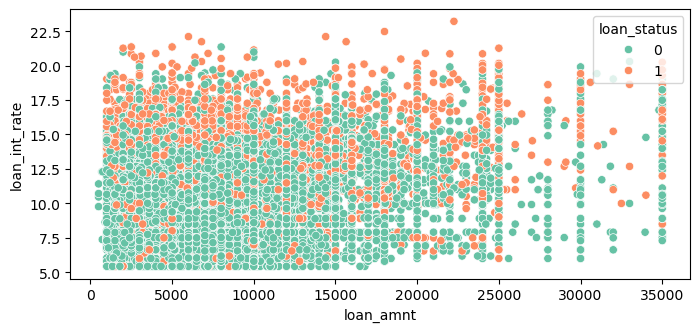

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (8, 3.5))

p2 = sns.scatterplot(df, x = "loan_amnt", y = "loan_int_rate", ax = ax, hue = "loan_status", palette="Set2")

# Patterns in the Data

We can discern from this visualization that in this dataset, whether a borrower defaults or not is not very dependent on the loan amount, but their interest rate, where borrowers with higher interest rates, usually greater than 13%, are more likely to default than borrowers with interest rates below 13%.

# Scatter plot 2 using `cb_person_default_on_file`

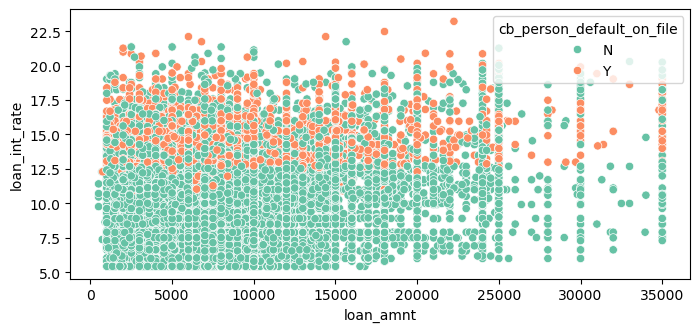

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize = (8, 3.5))

p2 = sns.scatterplot(df, x = "loan_amnt", y = "loan_int_rate", ax = ax, hue = "cb_person_default_on_file", palette="Set2")

# Patterns in the Data

Here we see a similar split between the data, whereby borrowers who have previously defaulted on their loans have higher interest rates then those who payed back their previous loan in full. As we have seen from the last visualization that interest rates are corellated with the rate of defaulting the loan, we may want to consider if they have previously defaulted in our prediction.

# Building the Prediction Model
In order to build our model, we are first going to have to prepare our data to support accurate prediction. 

# Data Processing
Our first step to processing the data to be trained is to drop unnessecary rows and columns. In this instance, we must drop all rows that do not contain a value for one of their columns, as well as our target variable loan status and loan grade. We use `X = pd.get_dummies(X)` to hot encode our categorical features such as `loan_intent`, `person_home_ownership`, and `cb_person_default_on_file`, store our target variable in the variable `y`, and use sklearn's `train_test_split` to split the data into training and testing data for cross validation.

In [9]:
from sklearn.model_selection import train_test_split

def prepare_data(df):    
    df = df.dropna()
    X = df.drop(["loan_grade", "loan_status"], axis=1)  
    X = pd.get_dummies(X)
    y = df["loan_status"]
    return X, y
X, y = prepare_data(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
21383,35,50532,8.0,5000,13.57,0.10,8,False,False,False,True,False,False,False,False,False,True,False,True
2116,25,60000,5.0,1200,13.85,0.02,2,False,False,True,False,False,False,False,False,False,True,True,False
5631,30,55000,1.0,6500,10.99,0.12,7,True,False,False,False,False,False,True,False,False,False,True,False
20675,30,34046,2.0,12000,14.96,0.35,6,False,False,False,True,False,False,False,True,False,False,False,True
9582,23,70522,7.0,9325,10.91,0.13,3,False,False,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13577,32,52000,0.0,2500,8.88,0.05,10,False,False,False,True,False,False,False,False,True,False,True,False
24532,36,60000,7.0,17050,12.69,0.28,14,True,False,False,False,True,False,False,False,False,False,True,False
6125,22,27264,4.0,5000,13.11,0.18,3,False,False,False,True,False,True,False,False,False,False,False,True
974,35,50000,0.0,5600,12.53,0.11,7,True,False,False,False,False,True,False,False,False,False,False,True


# Picking the Features and Fitting the Model
We will be using sklearn's `SelectKBest` with the scoring function `mutual_info_classif` to get the most predictive features, limiting the number of features to 6 to lower the amount of iterations the machine learning model must compute.

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=6)
X_selected = selector.fit_transform(X_train, y_train)

features = X.columns[selector.get_support()]

print(features)

Index(['person_income', 'loan_int_rate', 'loan_percent_income',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_RENT',
       'cb_person_default_on_file_N'],
      dtype='object')


# Building the Model

Now that we have obtained our features, we create a logistic regression model and train it on `X_train`, using only our selected models with `X_train[features]`. After fitting the model, we can produce a score that will show our models predictive accuracy.

In [11]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=50000)
LR.fit(X_train[features], y_train)
LR.score(X_train[features], y_train)


0.8474761255115962

# Results

We see through our score that we got a higher predictive accuracy than our base rate of 78%, showing that are model indeed learned patterns through our training data and selected features.

In [31]:
LR.score(X_test[features], y_test)

0.8384984722828459

We get similar results on new data, showing that are model was able to create generalizations that can be extrapolated to predict unseen data.

# Our Goal
Our goal now is to find a threshold that will provide a binary answer to the question of whether our not the bank should give a loan to a potential appliant and to compute the overall profit gained or lost by the bank.

# Approach
The apporach we will be taking is to first calculate a score to give each applicant `s`, with that score being the likelihood of whether or not an applicant will default on their loan or not. If this score is higher than our choosen threshold, the model will predict that the applicant will default on the loan and the bank will not lend to the applicant. If this score is lower or equal to our choosen threshold, the bank will lend 

# Calculations
In order to evaluate the total profit that the bank gains or losses given a particular threshold value, we will assume for convience that if the loan is repaid in full, the profit for the bank is equal to `loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt` and if the borrower defaults on the loan, the “profit” for the bank is equal to `loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt`. If the bank doesn't give out a loan, their profit is 0 for that particular borrower.

# Weights
Our weights, stored in the variable in `LR.coef` where `LR` is our logistic regression model  shows an array with all of the weights for our chosen features respectively. This is also known as our weight vector, which we can then use to find the threshold in order for our model to produce a yes or no answer.

In [13]:
weight_vector = LR.coef_
weight_vector

array([[-1.08054136e-05,  2.91142437e-01,  7.80074168e+00,
         1.18823376e+00,  1.98583970e+00, -1.00706707e-01]])

# Finding a Threshold

In order to create an automated system that finds the threshold that maximizes the total profit, we are going to split this task up into two functions: `individual_profit`, and `find_threshold`.

# Individual Profit Function
This function takes the loan amount and loan interest rate of a borrower and computes based on their score and the threshold the profit that the bank will make dealing with this applicant. If the `score` is greater than our chosen `threshold`, the bank's profit will be 0, because the bank will not lend to the potiental borrower. In the case where the model predicts the applicant will repay the loan, we then are faced with two more options. If the applicant actaully did repay the loan, that the profit is the `repaid_profit` value discussed previously. If the bank lends to an applicant but they default, then the bank in this case will lose profit, shown by the value of `default_profit`.

In [35]:
import numpy as np
def individual_profit(loan_amnt, loan_int_rate, score, threshold, loan_status):
        loan_int_rate = loan_int_rate / 100
        repaid_profit = loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt
        defaulted_profit = loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt
        return np.where(score <= threshold, 
                        np.where(loan_status == 1, defaulted_profit, repaid_profit), 
                        0)

# Find Threshold Function
This function uses `np.linspace(0,1,1000)` to enumerate through 1000 threshold values evenly spaced between 0 and 1, and notes the total profit gained from that selected threshold with the value of `total_profit` using the `np.sum` function. If that profit is greater than our value for `max_profit`, then we update `max_profit` and `best_threshold` to reflect the threshold value that gives the bank the maximum profit.

In [36]:
import numpy as np
def find_threshold(df, y, features, model):
    max_profit = float("-inf")
    best_threshold = 0
    scores = model.predict_proba(df[features])[:, 1]
    thresholds = np.linspace(0, 1, 1000)
    for threshold in thresholds:
        total_profit = np.sum(individual_profit(df["loan_amnt"], df["loan_int_rate"], scores, threshold, y))
        if total_profit > max_profit:
            max_profit = total_profit
            best_threshold = threshold

    return best_threshold, max_profit
    

# Results
Our resulting function reports that the best threshold value is `0.44` which will predict a profit of `$25,728,462`.

In [40]:
best_threshold, max_profit = find_threshold(X_train, y_train.values, features, LR)
(best_threshold, max_profit)

(np.float64(0.44544544544544545), np.float64(25728462.290848892))

# Training Threshold to Profit Relationship
Through this graph, we can also demonstrate how the change in threshold value increases and decreases the profit the bank makes per loan borrower, showing that indeed a threshold value of approximately `0.4` results in the most profit for the bank.

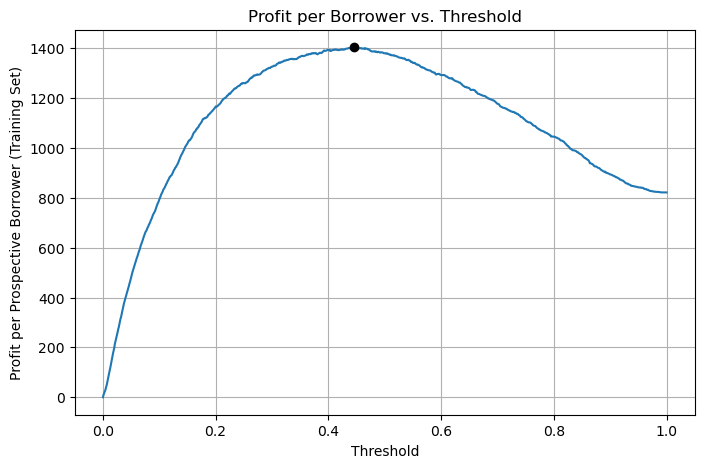

In [45]:
scores = LR.predict_proba(X_train[features])[:, 1]

# Store thresholds and profits per borrower
thresholds = np.linspace(0, 1, 1000)
profits_per_borrower = []
best_profit_per_borrower = max_profit / len(X_train)

for threshold in thresholds:
    total_profit = np.sum(individual_profit(
        X_train["loan_amnt"],
        X_train["loan_int_rate"],
        scores,
        threshold,
        y_train
    ))
    profit_per_borrower = total_profit / len(X_train)
    profits_per_borrower.append(profit_per_borrower)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(thresholds, profits_per_borrower)
ax.plot(best_threshold, best_profit_per_borrower, 'ko')
ax.set_ylabel("Profit per Prospective Borrower (Training Set)")
ax.set_xlabel("Threshold")
ax.set_title("Profit per Borrower vs. Threshold")
plt.grid(True)
plt.show()


# Model Evaluation: Bank's Perspective
To sum up our creation of a predictive decision making model, we are going to test it on the data stored in `df_test`.

In [52]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
X_df_test, y_df_test = prepare_data(df_test)
LR.fit(X_df_test[features], y_df_test)
# weight_vecator = LR.coef_
threshold, profit = find_threshold(X_df_test, y_df_test, features, LR)
threshold, profit

(np.float64(0.4194194194194194), np.float64(7703261.7572102975))

# Testing Results
Running our automated decision making system on the testing data gives a similar optimal threshold as the training data, proving that for this dataset a threshold value of around `0.4` results in the most profit for the bank.

# Model Evaluation: Borrower's Perspective
Lets now evaluate how the model treats individual borrowers based on their age, loan intent and income. the main questions we want to ask are those of discrimination: Is it more difficult for people in certain age groups to access credit? Is it more difficult for people to get loans in order to pay for medical expenses? How does a person’s income level impact the ease with which they can access credit?

# Differences in Age Groups Access To Credit
To answer this question we can make a summary table. We use the `pd.cut` function to make continous variables into categorical variables.

In [61]:
import pandas as pd
import numpy as np

# Create age groups
age_bins = [18, 25, 35, 50, 65, 100]
age_labels = ["<25", "25-35", "35-50", "50-65", ">65"]
df_test["age_group"] = pd.cut(df_test["person_age"], bins=age_bins, labels=age_labels)

# Prepare test data (ensure one-hot encoding matches training data)
X_df_test, y_df_test = prepare_data(df_test)
df_test_filtered = df_test.loc[X_df_test.index].copy()

# Predict scores using prepared data
scores = LR.predict_proba(X_df_test[features])[:, 1]

# Approval decision
df_test_filtered["approved"] = scores > threshold

# Compute acceptance rates by age group
age_acceptance_rates = df_test_filtered.groupby("age_group")["approved"].mean()
display(age_acceptance_rates)

/var/folders/pv/gfxr_25s0q9gt_2k6h_bbgmc0000gn/T/ipykernel_98691/2402408799.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_acceptance_rates = df_test_filtered.groupby("age_group")["approved"].mean()


age_group
<25      0.209654
25-35    0.175219
35-50    0.142857
50-65    0.268293
>65      0.000000
Name: approved, dtype: float64

# Results
What we can see from the function's output is that people higher in age (likely correlated with higher income) are more likely of being lent a loan.

# Difficuly Getting Loans for Medical Expenses

To answer this question, we will use the `pd.groupby()` function to group all of the applicants in `df_test` into the two groups `loan_intent_acceptance` which contains only the applicants that got their loan request approved and gets the percentage of those applicants whos loan intent was one of the following `loan_intent` values, and `loan_intent_default` which the same as `loan_intent_acceptance` except that it contains the true rate of default for that group.

In [63]:
loan_intent_acceptance = df_test_filtered.groupby(["loan_intent"])["approved"].mean()


loan_intent_default = df_test_filtered.groupby(["loan_intent"])["loan_status"].mean()  

loan_analysis = pd.DataFrame({
    "Acceptance Rate": loan_intent_acceptance,
    "Default Rate": loan_intent_default
})
display(loan_analysis)

,Acceptance Rate,Default Rate
loan_intent,,
DEBTCONSOLIDATION,0.200221,0.287611
EDUCATION,0.176871,0.167517
HOMEIMPROVEMENT,0.154221,0.250000
MEDICAL,0.211556,0.284250
PERSONAL,0.201403,0.220441
VENTURE,0.176349,0.146266


# Income Level vs Access to Credit
To answer this question we take the same approach we took in tacking difference in loan availibility based on age groups to answer the question based on income groups.

In [66]:
# Add income group to the filtered DataFrame
income_bins = [0, 30000, 60000, 100000, 500000]
income_labels = ["<30K", "30K-60K", "60K-100K", ">100K"]

df_test_filtered["income_group"] = pd.cut(df_test_filtered["person_income"], bins=income_bins, labels=income_labels)

# Group by income group and compute acceptance rate
income_acceptance_rates = df_test_filtered.groupby("income_group")["approved"].mean()
display(income_acceptance_rates)

/var/folders/pv/gfxr_25s0q9gt_2k6h_bbgmc0000gn/T/ipykernel_98691/1191128577.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_acceptance_rates = df_test_filtered.groupby("income_group")["approved"].mean()


income_group
<30K        0.383007
30K-60K     0.234381
60K-100K    0.105170
>100K       0.028302
Name: approved, dtype: float64

# Results
Here, we see that applicants who have a higher income have a much higher chance of getting a loan request accepted then applicants with lower incomes.

# Overall Reflection
Here we highlight notable problems with a decision making algorithm deciding whether or not applicants deserve loans or not. As the model, weights, and threshold were decided with the intention of garnering the bank with the maximum amount of profit, there were considerable issues regarding how the model treated individual applicants. My findings note that the need for the loan (due to lower age, income, or important reasons such as a medical expenses) is inversely related to the availability of the loan under this decision making system. 